# fig_egBeh

### This notebook generates figures related to generating example subject behavior 

#### Part 1: Systemic RT Variability - between delay condition (with differences in temporal expectaction):
    * show differences in RT distributions
    * LATER model fits
#### Part 2: Stochastic RT Variability - based on memories of past trials:
    * show differences in RT distributions
    * memReg model fits
    
 
    
    

In [1]:
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['font.size'] = 16
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/fig_egBeh/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
    
    

def clean_fig(apply_int=True,n_bins = 3):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],n_bins))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],n_bins))
    if apply_int==True:
        plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=30)
        plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=30)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=30)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=30)

def getBehData(S):
    
    # collect error and fast response rate
    choiceEv = S.ev_df.query('type=="RESPONSE"')
    evQuery_correct = 'error==0&fastResponse==0'
    
    fp_dict={}
    fp_dict['subj'] = S.subj
    fp_dict['n_trials'] = len(choiceEv)
    fp_dict['n_sess'] = len(np.unique(choiceEv['session']))
    fp_dict['mean_rt'] = np.mean(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    fp_dict['std_rt'] = np.std(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    
    fp_dict['mean_rtL'] = np.mean(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['std_rtL'] = np.std(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['mean_rtS'] = np.mean(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['std_rtS'] = np.std(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    
    
    # rt diff
    fp_dict['rtDiff_mean'] = fp_dict['mean_rtL'] - fp_dict['mean_rtS']
    fp_dict['rtDiff_std'] = fp_dict['std_rtL'] - fp_dict['std_rtS']
    
    
    fp_dict['error_rate'] = (np.sum(choiceEv.eval('RT<0'))/len(choiceEv))
    fp_dict['error_rateS'] = (np.sum(choiceEv.eval('RT<0&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['error_rateL'] = (np.sum(choiceEv.eval('RT<0&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['error_diff'] = fp_dict['error_rateL'] - fp_dict['error_rateS']
    
    fp_dict['lapse_rate'] = (np.sum(choiceEv.eval('RT>=1000'))/len(choiceEv))
    fp_dict['lapse_rateS'] = (np.sum(choiceEv.eval('RT>=1000&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['lapse_rateL'] = (np.sum(choiceEv.eval('RT>=1000&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['lapse_diff'] = fp_dict['lapse_rateL'] - fp_dict['lapse_rateS']
    
    # fit LATER2
    rts_A,rts_B,pred_idx_A,pred_idx_B = S.getRTs_for_LATER2()

    # FIT LATER 2
    fp_dict.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,model_type = 'std_bias'))
    
    return fp_dict


/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


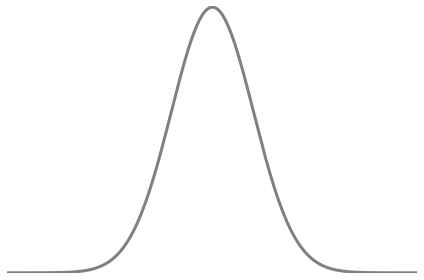

In [2]:
# eg gaussian
norm =  stats.norm(loc = 0, scale = 2)
x = np.arange(-10,10,0.1);
y = norm.pdf(x)
plt.plot(x,y,color = '0.5',linewidth=3)
plt.gca().axis('off')
save_fig('eg_gauss')

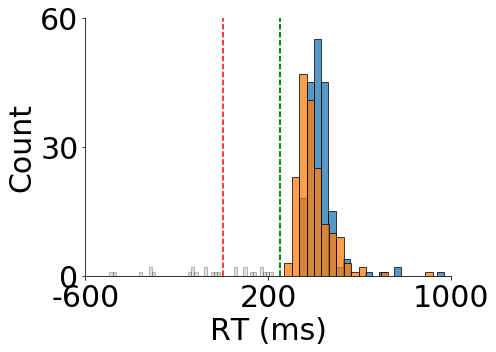

In [3]:
# SUBJECT 179

S = cc.Subject('HUP179')
subj_dict = getBehData(S)
f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

# plot short delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = 0.75,
     bins = 20)
# plot long delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = 0.75,
     bins = 20)
ax.vlines((250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('green'))


# plot anticipatory false alarms
S.plotRT(ax = ax,evQuery='RT<250&RT>-500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='0.5',
     alpha = 0.25,
     bins = 50)
ax.set_ylabel('count',fontsize=30)
ax.set_xlabel('RT (ms)',fontsize=30)
S.set_axes_rt(ax=plt.gca(),plot_type = 'standard',add_legend=False)
ax.vlines((0,250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('red','green'))
clean_fig()
#plt.gca().text(500,30,'$\Delta$ mean RT \n     $=$ \n'+str(np.round(subj_dict['rtDiff_mean'],2))+' ms',fontsize=20)
#plt.gca().text(-550,30,'anticipatory \nfalse alarm \nrate = '+str((subj_dict['error_rate']*100).astype('int'))+' %',fontsize=20)
save_fig('egRT_HUP179')


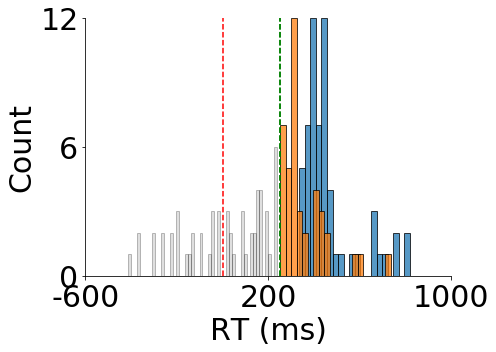

In [4]:
# SUBJECT 133

S = cc.Subject('HUP133')
subj_dict = getBehData(S)
f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

# plot short delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = 0.75,
     bins = 20)
# plot long delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = 0.75,
     bins = 20)
ax.vlines((250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('green'))


# plot anticipatory false alarms
S.plotRT(ax = ax,evQuery='RT<250&RT>-500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='0.5',
     alpha = 0.25,
     bins = 50)
ax.set_ylabel('count',fontsize=30)
ax.set_xlabel('RT (ms)',fontsize=30)
S.set_axes_rt(ax=plt.gca(),plot_type = 'standard',add_legend=False)
ax.vlines((0,250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('red','green'))
clean_fig()
#plt.gca().text(500,5,'$\Delta$ mean RT \n     $=$ \n'+str(np.round(subj_dict['rtDiff_mean'],2))+' ms',fontsize=20)
#plt.gca().text(-550,5,'anticipatory \nfalse alarm \nrate = '+str((subj_dict['error_rate']*100).astype('int'))+' %',fontsize=20)
save_fig('egRT_HUP133')

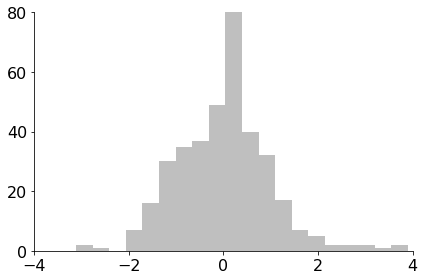

In [5]:
S = cc.Subject('HUP179')
f = plt.figure()
ax = plt.subplot(111)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0',\
     plot_type='zrrt',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='0.5',
     alpha = 0.5,
     bins = 20)
save_fig('egRT_HUP179_bland')

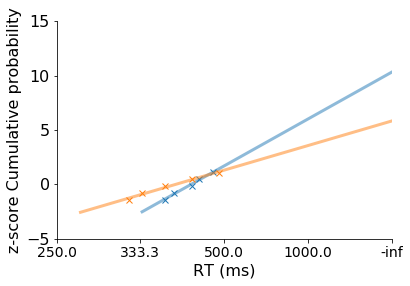

In [7]:
S = cc.Subject('HUP179')
f = plt.figure()
ax = plt.subplot(111)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
     plot_type='reciprobit',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = 0.5,
     bins = 20,apply_reciprobit_smooth=False)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
     plot_type='reciprobit',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = 0.5,
     bins = 20,apply_reciprobit_smooth=False)
S.set_axes_rt(ax=plt.gca(),plot_type = 'reciprobit',add_legend=False)
#plt.gca().set_xticklabels(str(-1*plt.gca().get_xticks()[0]))
#save_fig('egRT_HUP179')

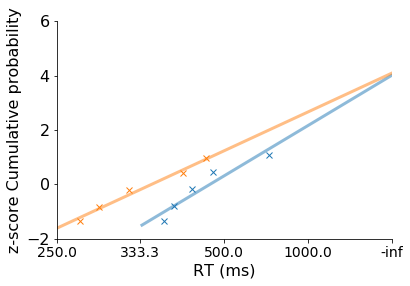

In [8]:
S = cc.Subject('HUP133')
f = plt.figure()
ax = plt.subplot(111)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
     plot_type='reciprobit',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = 0.5,
     bins = 20,apply_reciprobit_smooth=False)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
     plot_type='reciprobit',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = 0.5,
     bins = 20,apply_reciprobit_smooth=False)
S.set_axes_rt(ax=plt.gca(),plot_type = 'reciprobit',add_legend=False)
#plt.gca().set_xticklabels(str(-1*plt.gca().get_xticks()[0]))
#save_fig('egRT_HUP179')

KeyError: '1000_params'

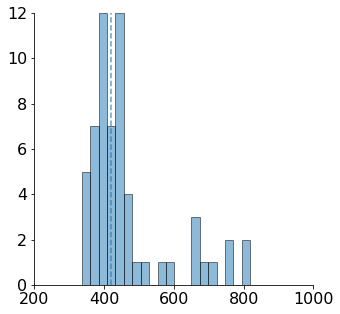

In [9]:
S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',plot_type='standard',plot_median=True)
plt.savefig(fname = fig_dir+'rt_example_std.pdf')

S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',plot_type='reciprocal',plot_median=True)
plt.savefig(fname = fig_dir+'rt_example_reciprocal.pdf')

S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',plot_type='zrrt',plot_median=True)
plt.savefig(fname = fig_dir+'rt_example_zrrt.pdf')

S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',\
                   plot_type='reciprobit',plot_median=True,yL=(-2,2))
plt.savefig(fname = fig_dir+'rt_example_reciprobit.pdf')

KeyError: 'xval_pdf'

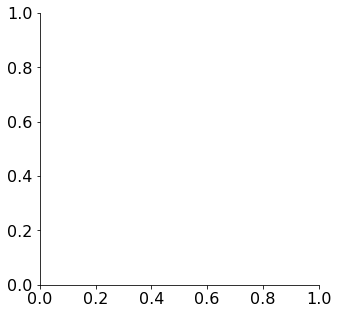

In [11]:
S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',plot_type='LATER',plot_median=True)
plt.savefig(fname = fig_dir+'LATER_example_zrrt.pdf')

S.plot_RT_by_delay(evQuery='error==0&fastResponse==0',\
                   plot_type='LATER_reciprobit',plot_median=True,yL=(-2,2))
plt.savefig(fname = fig_dir+'LATER_example_reciprobit.pdf')

In [5]:
# plot time series
S.fitMemoryRegression(evQuery='error==0&fastResponse==0');


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1042: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1066: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1084: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))


tau:  4.995600927538982


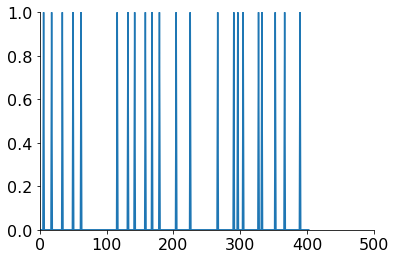

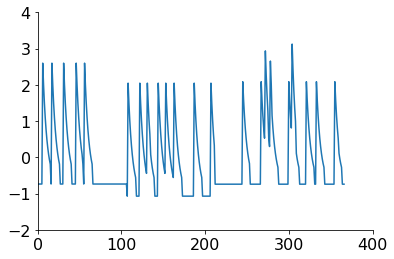

In [10]:
# example feature to memory
print('tau: ', S.memReg_dict['tau'])

plt.figure()
plt.plot(S.ev_df_master.query('type=="RESPONSE"').eval('RT<0').to_numpy())
ax = plt.gca()

plt.figure()
plt.plot(S.memReg_dict['errorMemFast'])

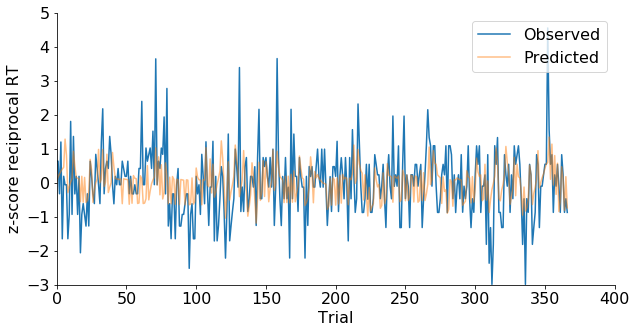

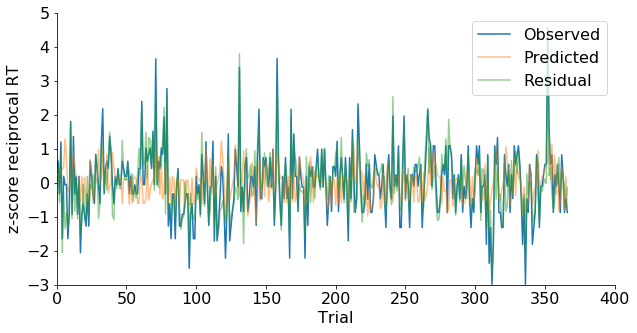

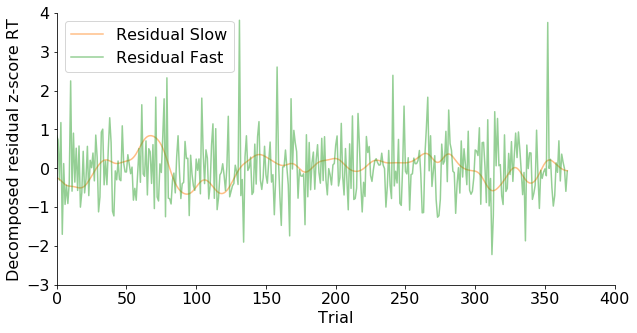

In [17]:
# print RT Predicted
plt.figure(figsize=(10,5))
plt.plot(S.memReg_dict['zrrt'],label = 'Observed')
plt.plot(S.memReg_dict['zrrt_pred'],alpha =0.5,label = 'Predicted')
ax = plt.gca()
ax.set_xlabel('Trial')
ax.set_ylabel('z-score reciprocal RT')
plt.legend()


plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(S.memReg_dict['zrrt'],label = 'Observed')
plt.plot(S.memReg_dict['zrrt_pred'],color = 'C1',alpha =0.5,label = 'Predicted')
plt.plot(S.memReg_dict['zrrt_resid'],color = 'C2',alpha =0.5,label = 'Residual')
ax.set_xlabel('Trial')
ax.set_ylabel('z-score reciprocal RT')
plt.legend()



plt.figure(figsize=(10,5))
plt.plot(S.memReg_dict['zrrt_resid_slow'],alpha =0.5,color = 'C1',label = 'Residual Slow')
plt.plot(S.memReg_dict['zrrt_resid_fast'],alpha =0.5,color = 'C2',label = 'Residual Fast')
ax = plt.gca()
ax.set_xlabel('Trial')
ax.set_ylabel('Decomposed residual z-score RT')
plt.legend()

